In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer_2 import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.7.1+cu126
CUDA available: True
CUDA version: 12.6
GPU name: NVIDIA GeForce GTX 1650


In [3]:
aligned_path = PROJECT_ROOT / 'additional_data' / 'Vivek_prostate_aligned_mri_us'
aligned_mri = "mr000000_registered.nii.gz"
aligned_us = "us000000.nii.gz"

aligned_mri_img = nib.load(str(aligned_path / aligned_mri))
aligned_mri_vol = aligned_mri_img.get_fdata(dtype=np.float32)
aligned_mri_affine = aligned_mri_img.affine
aligned_us_img = nib.load(str(aligned_path / aligned_us))
aligned_us_vol = aligned_us_img.get_fdata(dtype=np.float32)
aligned_us_affine = aligned_us_img.affine

In [4]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

# Preliminary computations

In [5]:
aligned_us_vol = aligned_us_vol.squeeze(-1)

In [6]:
aligned_mri_vol.shape, aligned_us_vol.shape

((120, 128, 128), (81, 118, 88))

In [7]:
aligned_mri_affine, aligned_us_affine

(array([[ 0.80000001,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.80000001, -0.        , -0.        ],
        [ 0.        ,  0.        ,  0.80000001,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]))

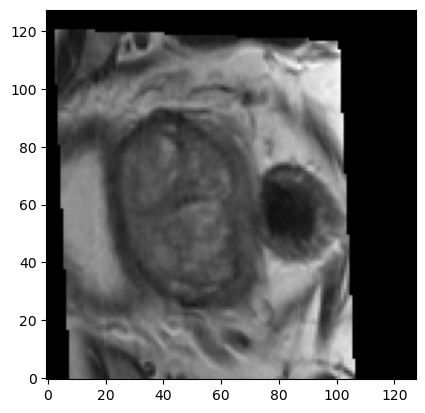

In [8]:
plt.imshow(aligned_us_vol[39, :, :], cmap='gray', origin='lower')
plt.imshow(aligned_mri_vol[59, :, :], cmap='gray', origin='lower')

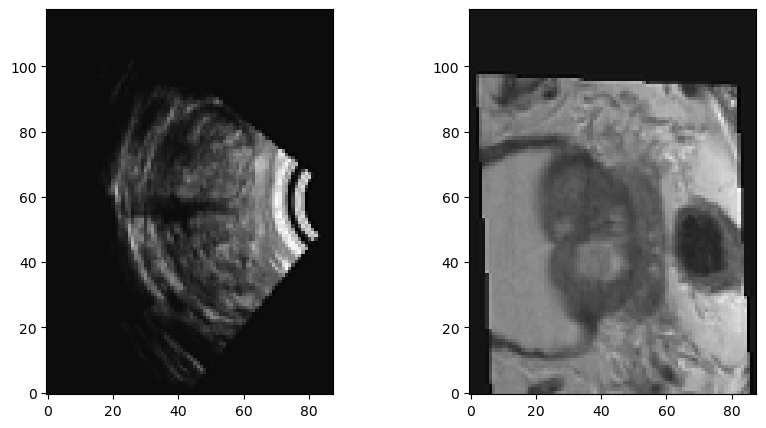

In [9]:
import nibabel as nib
from nibabel.processing import resample_from_to

# Suppose you have:
# aligned_mri_vol: numpy array
# aligned_mri_affine: 4x4 numpy array
# aligned_us_vol: numpy array
# aligned_us_affine: 4x4 numpy array

# Create Nifti images
mri_img = nib.Nifti1Image(aligned_mri_vol, aligned_mri_affine)
us_img = nib.Nifti1Image(aligned_us_vol, aligned_us_affine)

# Resample MRI to US grid (shape and affine)
mri_resampled_img = resample_from_to(mri_img, us_img)
mri_resampled_vol = mri_resampled_img.get_fdata()

# Now you can overlay slices pixel-perfectly:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aligned_us_vol[39, :, :], cmap='gray', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(mri_resampled_vol[59, :, :], cmap='gray', origin='lower')
plt.show()

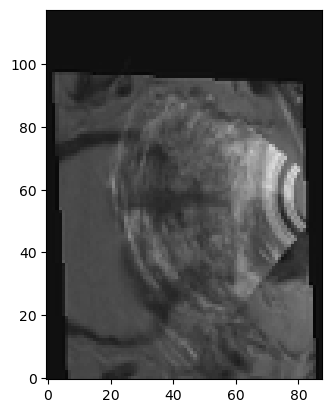

In [10]:
plt.imshow(mri_resampled_vol[59, :, :], cmap='gray', origin='lower')
plt.imshow(aligned_us_vol[39, :, :], cmap='gray', origin='lower', alpha=0.5)


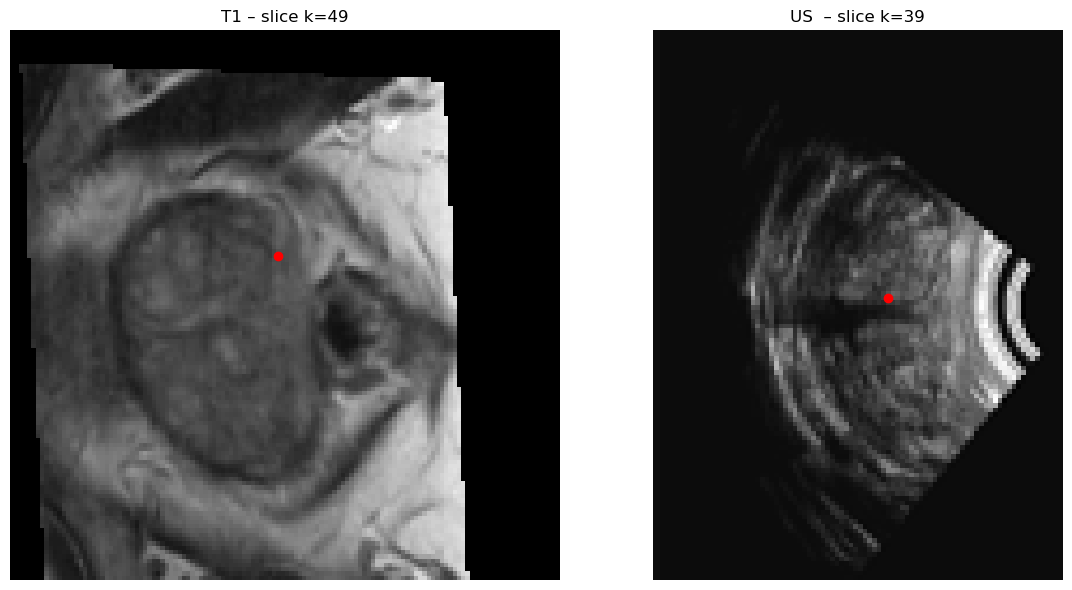

In [11]:
slice_idx, i_us, j_us = 39, 50, 60 # Example indices for T1 MRI
mri_slice, mri_idx = us_to_mri_point(i_us, j_us, slice_idx, aligned_us_vol, aligned_us_affine, aligned_mri_vol, aligned_mri_affine)
plot_mri_us_aligned_0(i_us, j_us, slice_idx, aligned_us_vol, mri_slice, mri_idx)

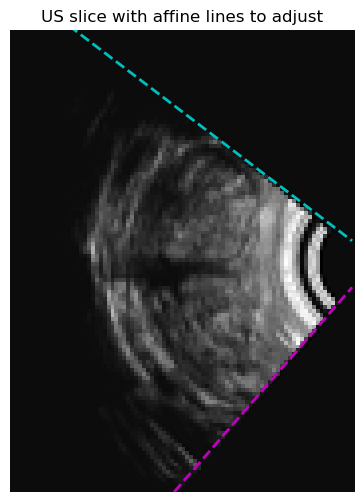

In [16]:
# US edges parameters
mL, bL = -0.76, 130  # Left edge line parameters (slope, intercept)
mR, bR = 1.15, -48  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(aligned_us_vol[39, :, :], mL, bL, mR, bR)

k_mri, _, _ = mri_idx
H_mri, W_mri = mri_slice.shape
us_slice = aligned_us_vol[39, :, :]

In [14]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = 1.6
direction_vec   = np.array([-0.99474214,-0.10241128])

Source : (93.19371727748691, 59.17277486910994)


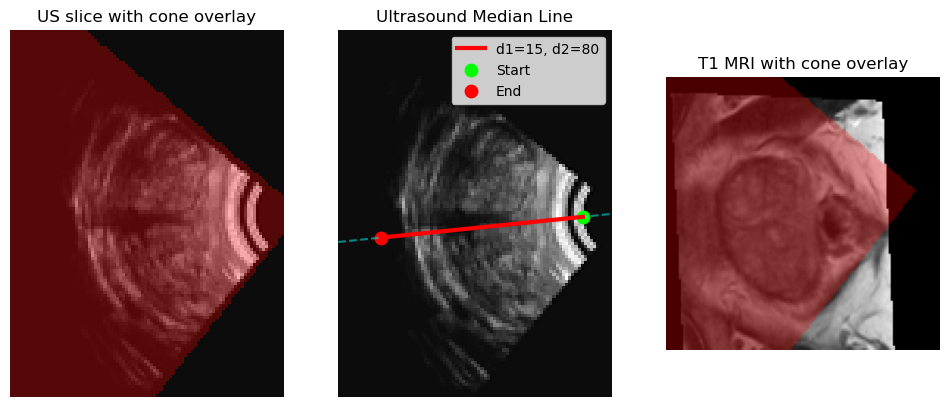

In [17]:
mask_us = overlay_cone(us_slice, apex=np.array([x0, y0]), direction_vector=direction_vec, opening_angle=opening_angle)
fig, ax = plt.subplots(1,3, figsize=(12, 6))
plot_overlay_cone(us_slice, mask_us, ax=ax[0])
plot_median_line(us_slice, (x0,y0), direction_vec, d1=15, d2=80, ax=ax[1])

t1_slice = aligned_mri_vol[k_mri, :, :]
H_t1, W_t1 = t1_slice.shape
apex_us_vox = np.array([slice_idx, x0, y0])

apex_mri_world, direction_mri_world = cone_us_to_mri_world(apex_us_vox, direction_vec, aligned_us_affine, aligned_mri_affine)

# Visualize result
mask_mri = overlay_cone(t1_slice, apex=apex_mri_world[1:], direction_vector=direction_mri_world, opening_angle=opening_angle)
plot_overlay_cone(t1_slice, mask_mri, ax=ax[2], title="T1 MRI with cone overlay")

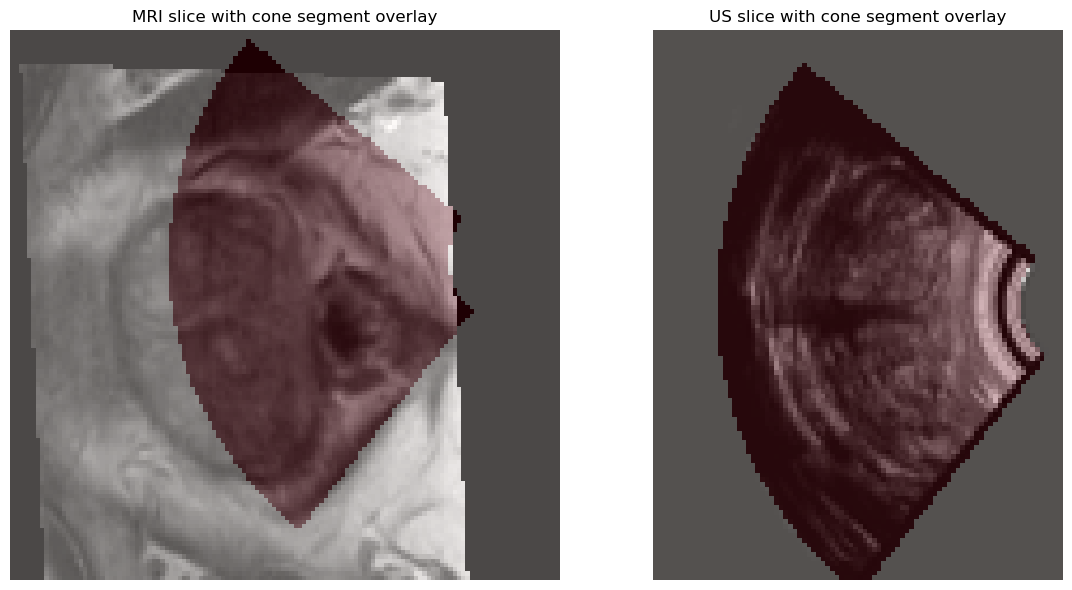

In [18]:
import numpy as np

def depr_mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction.
    mask: 2D boolean array (the cone mask)
    apex: (x0, y0) coordinates (float)
    direction: (dx, dy) unit vector (float)
    d1, d2: distances from apex (float)
    Returns: new mask (bool)
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Create coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction
    proj = vx * dx + vy * dy
    # Keep only points between d1 and d2
    segment_mask = (proj >= d1) & (proj <= d2)
    return mask & segment_mask

#rounded version
def mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction,
    with rounded caps at d1 and d2.
    
    Parameters:
        mask: 2D boolean array (the cone mask)
        apex: (x0, y0) coordinates (float)
        direction: (dx, dy) unit vector (float)
        d1, d2: distances from apex (float)
        
    Returns:
        mask_segment: 2D boolean array with rounded cone segment
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction (how far along the cone axis)
    proj = vx * dx + vy * dy

    # Project each point onto the median direction
    proj = vx * dx + vy * dy

    # Calculate distance from apex to each point
    dist = np.sqrt(vx**2 + vy**2)
    # Create a mask for points within the rounded caps

    rounded_mask_d1 = dist >= d1
    rounded_mask_d2 = dist <= d2
    # Combine the masks
    mask = mask & (rounded_mask_d1 | rounded_mask_d2)
    return mask & rounded_mask_d1 & rounded_mask_d2


apex = apex_mri_world[1:]
d1, d2 = 15, 80

mask_segment_mri = mask_cone_segment(mask_mri, apex, direction_mri_world, d1, d2)
mask_segment_us = mask_cone_segment(mask_us, np.array([x0, y0]), direction_vec, d1, d2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(t1_slice, cmap='gray', origin='lower')
axs[0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3, origin='lower')
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world)
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([0.0, v[0], v[1]])
    return torch.tensor(directions, dtype=torch.float32)

In [38]:
start = d1
n_rays = 64
source = np.array([k_mri, x0, y0])
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

In [46]:
renderer = UltrasoundRenderer(num_samples=d2, attenuation_coeff=0.0001)
x,z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(aligned_mri_vol),
            source=torch.tensor(source),
            directions=torch.tensor(directions),
            angle=0,
            plot=False,
            artifacts=False,
            start=start
        )

C:\Users\g630d\AppData\Local\Temp\ipykernel_19712\3414884061.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([49.0000, 93.1937, 59.1728], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 15 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 15 torch.Size([64, 81])
x_coords: torch.Size([4224]) z_coords: torch.Size([4224]) intensities: torch.Size([4224])


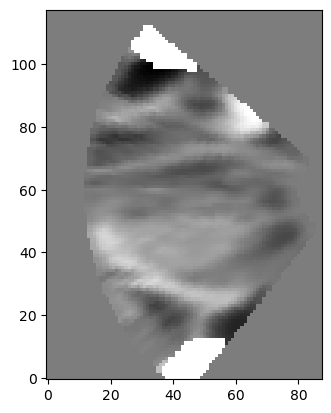

In [47]:
H, W = aligned_us_vol[k_mri,:,:].shape
synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

# Train MLP to find Z_vol (Acoustic Impedance)

In [21]:
n_rays = 64
source = torch.tensor(apex_mri_world)
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

us_slice = aligned_us_vol[39, :, :]
us_real = us_slice
cone_mask = mask_segment_us

directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)
print(source, directions, np.degrees(opening_angle))

tensor([ 48.7500, 116.4921,  73.9660], dtype=torch.float64) tensor([[ 0.0000, -0.7665,  0.6422],
        [ 0.0000, -0.7826,  0.6226],
        [ 0.0000, -0.7981,  0.6025],
        [ 0.0000, -0.8132,  0.5820],
        [ 0.0000, -0.8277,  0.5612],
        [ 0.0000, -0.8417,  0.5400],
        [ 0.0000, -0.8551,  0.5184],
        [ 0.0000, -0.8680,  0.4966],
        [ 0.0000, -0.8803,  0.4744],
        [ 0.0000, -0.8921,  0.4518],
        [ 0.0000, -0.9033,  0.4290],
        [ 0.0000, -0.9139,  0.4060],
        [ 0.0000, -0.9239,  0.3826],
        [ 0.0000, -0.9333,  0.3591],
        [ 0.0000, -0.9421,  0.3352],
        [ 0.0000, -0.9503,  0.3112],
        [ 0.0000, -0.9579,  0.2870],
        [ 0.0000, -0.9649,  0.2625],
        [ 0.0000, -0.9713,  0.2380],
        [ 0.0000, -0.9770,  0.2132],
        [ 0.0000, -0.9821,  0.1883],
        [ 0.0000, -0.9866,  0.1633],
        [ 0.0000, -0.9904,  0.1382],
        [ 0.0000, -0.9936,  0.1130],
        [ 0.0000, -0.9961,  0.0878],
        [ 0.000

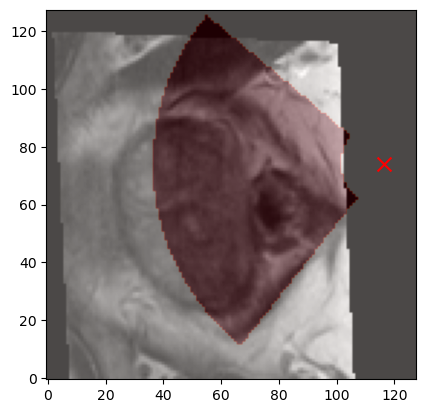

In [23]:
plt.imshow(aligned_mri_vol[k_mri,:, :], cmap='gray', origin='lower')
plt.imshow(mask_segment_mri, cmap='Reds', origin="lower", alpha=0.3)
plt.scatter(
    apex_mri_world[1], 
    apex_mri_world[2], 
    c='red', s=100, label='Apex', marker='x'
)


# REMASTERED 2

In [24]:
device = torch.device('cpu')
print(device)

cpu


In [28]:
class ImpedanceLearner(nn.Module):
    """Learning the mapping MRI -> Acoustic Impedance"""
    def __init__(self, input_dim=1, hidden_dims=[32, 32]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
        self.mlp.to(device)
        self.to(device)  # in your model's __init__ or before training
    
    def forward(self, x):
        x = x.to(device)
        original_shape = x.shape
        x_flat = x.reshape(-1, 1)
        out_flat = self.mlp(x_flat)
        return out_flat.reshape(original_shape)

    
    def training_forward(self, 
                         renderer:UltrasoundRenderer,
                         x:torch.Tensor,
                         source:torch.Tensor,
                         directions:torch.Tensor,
                         angle:float,
                         start:float=0.4):
        """
        Forward pass for training, returns impedance values.
        x: T1_vol
        """
        # assuming that training plane direction is [:,:, fixed slice]
        # x_flat = x[:, :, slice_idx].reshape(-1, 1)  # Flatten the slice
        # Z_vol  = self.mlp(x_flat).view_as(x[:, :, slice_idx]).unsqueeze(2)  # Reshape to match the original slice shape
        x = x.to(device)
        source = source.to(device)
        directions = directions.to(device)

        x_slice = x[slice_idx, :, :]
        print(x_slice.device, x_slice.shape)
        Z_slice = self.forward(x_slice).to(device)
        print(Z_slice.device, Z_slice.shape)
        Z_vol = x.clone()
        Z_vol[slice_idx, :, :] = Z_slice
        print(Z_vol.device)

        # Z_vol = self.forward(x).to(device)

        # remder the synthetic ultrasound
        x,z,intensities = renderer.plot_beam_frame(
            volume=Z_vol, # issue here, this SHOULD NOT BE DETACHED THAT IS THE WHOLE POINT
            source=source,
            directions=directions,
            angle=angle,
            plot=False,
            artifacts=False,
            start=start
        )

        # returned the x, z coordinates and intensities, relative to the apex
        # Note pour gabi: x and z are in the same coordinate system as the source, with an up vector pointing towards the median
        return x,z, intensities
       
class UltrasoundSynthesisModel:

    def __init__(self,
                 renderer:UltrasoundRenderer,
                 impedance_model:ImpedanceLearner,
                 us_real:torch.Tensor,
                 mask:torch.Tensor,
                 source:torch.Tensor,
                 directions:torch.Tensor,
                 angle:float=45.0,
                 ):
        """
        renderer: UltrasoundRenderer
        impedance_model: ImpedanceLearner
        us_real: Real ultrasound tensor (n_rays, depth)
        mask: (n_rays, depth)
        source: (3,)
        directions: (n_rays, 3)
        """
        self.renderer = renderer
        self.impedance_model = impedance_model.to(device)

        self.us_real            = torch.tensor(us_real).to(device)
        self.mask = torch.tensor(mask).to(device)
        self.source = source.to(device)
        self.directions = directions.to(device)
        self.angle = angle
        # Normalize the real ultrasound data
        self.real_min = us_real.min()
        self.real_max = us_real.max()
        self.us_real_norm = ((us_real - self.real_min) / (self.real_max - self.real_min + 1e-8))
        self.us_real_norm = torch.tensor(self.us_real_norm).to(device)
        self.impedance_model.train()
    
    def gradient_loss(self, a, b, mask):
        """Loss robust to edge artifacts"""
        a_grad = torch.abs(a[:, 1:] - a[:, :-1])
        b_grad = torch.abs(b[:, 1:] - b[:, :-1])
        return F.l1_loss(a_grad[mask[:, 1:]], b_grad[mask[:, 1:]])

    def loss(self, synth_us):
        """Compute the loss between synthetic and real ultrasound"""
        print(type(synth_us), type(self.us_real_norm))
        main_loss = F.mse_loss(synth_us[self.mask], self.us_real_norm[self.mask])
        edge_loss = self.gradient_loss(synth_us, self.us_real_norm, self.mask)
        return main_loss + 0.5 * edge_loss
    
    def train_step(self, t1_volume, optimizer):
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated() / 1e6, 'MB allocated')
        print(torch.cuda.memory_reserved() / 1e6, 'MB reserved')
        
        # Forward pass through the model to get synthetic ultrasound
        
        x, z, synth_us_flat = self.impedance_model.training_forward(
            renderer=self.renderer,
            x=t1_volume,
            source=self.source,
            directions=self.directions,
            angle=self.angle,  # or pass as argument if variable
        )
        
        H, W = self.us_real.shape
        synth_img = differentiable_splat(x.to(device), 
                                        z.to(device), 
                                        synth_us_flat.to(device), 
                                        H=H, W=W, sigma=0.5)
        
        # Compute loss and backpropagate
        loss_value = self.loss(synth_img)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        item = loss_value.item()

        del x, z, synth_us_flat, synth_img, loss_value
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated() / 1e6, 'MB allocated')
        print(torch.cuda.memory_reserved() / 1e6, 'MB reserved')
        

        return item
        
    def train(self, t1_volume, optimizer, num_epochs=1000):
        """
        Train the impedance model on the T1 volume.
        """
        t1_volume = t1_volume.to(device)
        losses = []
        for epoch in range(num_epochs):
            loss_val = self.train_step(t1_volume, optimizer)
            losses.append(loss_val)
            print(f"Epoch {epoch:4d} | Loss: {loss_val:.6f}")
        return losses

In [29]:
model_one = ImpedanceLearner(1)
mask_one = mask_segment_us
renderer_one = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)
optimizer_one = torch.optim.Adam(model_one.parameters(), lr=0.001)  

USM = UltrasoundSynthesisModel(
    renderer=renderer_one,
    impedance_model=model_one,
    us_real=us_slice,
    mask=mask_segment_us,
    source=torch.tensor(apex_mri_world),
    directions=directions.flip(0),
    angle=np.degrees(opening_angle)/2
)


In [30]:
USM.train(
    t1_volume=torch.tensor(aligned_mri_vol, dtype=torch.float32),
    optimizer=optimizer_one,
    num_epochs=1
)

0.0 MB allocated
0.0 MB reserved
cpu torch.Size([128, 128])
cpu torch.Size([128, 128])
cpu
[INFO] Tracing rays with source: tensor([ 48.7500, 116.4921,  73.9660], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 91 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 91 torch.Size([64, 229])
x_coords: torch.Size([8832]) z_coords: torch.Size([8832]) intensities: torch.Size([8832])
<class 'torch.Tensor'> <class 'torch.Tensor'>
0.0 MB allocated
0.0 MB reserved
Epoch    0 | Loss: nan


[nan]

In [ ]:
synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

In [ ]:
# USM.train(
#     t1_volume=torch.tensor(T1_vol, dtype=torch.float32),
#     optimizer=optimizer_one
# )

## Plotting the results

The code below corrects the direction and orientation.

cpu torch.Size([128, 128])
cpu torch.Size([128, 128])
cpu
[INFO] Tracing rays with source: tensor([ 48.7500, 116.4921,  73.9660], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 229])
x_coords: torch.Size([7616]) z_coords: torch.Size([7616]) intensities: torch.Size([7616])


C:\Users\g630d\AppData\Local\Temp\ipykernel_19712\4038122840.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_19712\4038122840.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_19712\4038122840.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



ValueError: operands could not be broadcast together with shapes (256,256) (118,88) 

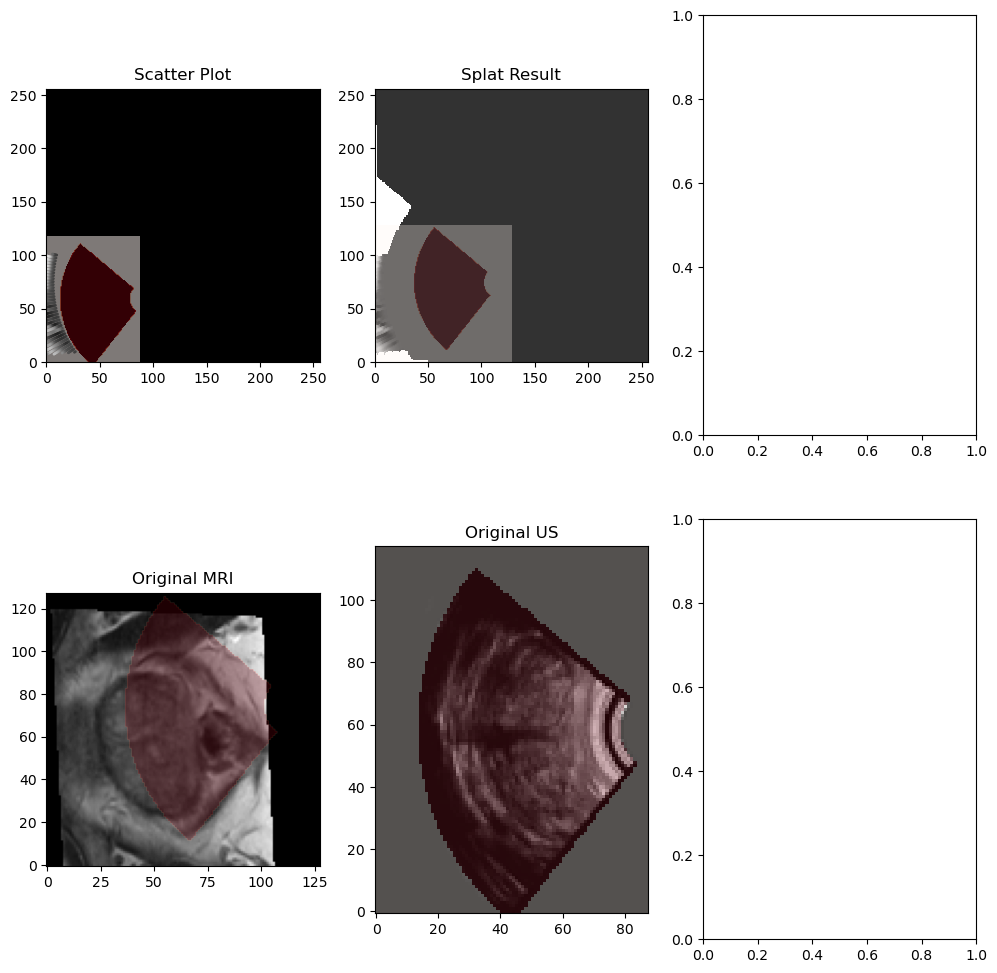

In [ ]:
out_2 = model_one.training_forward(
    renderer=renderer_one,
    x=torch.Tensor(aligned_mri_vol),
    source=torch.tensor(apex_mri_world),
    directions=directions.flip(0),
    angle=np.degrees(opening_angle)/2,  # Convert radians to degrees
    start=110
)

x,z, intensities = out_2
import torch

x = x.float().detach().cpu()
z = z.float().detach().cpu()
# apex = torch.tensor(apex_mri_world[:2], dtype=torch.float32)
# median = torch.tensor([-0.3, -0.9], dtype=torch.float32)
intensities = intensities.float().detach().cpu()

# x,z = rotate_around_apex(x, 
#                                   z, 
#                                   apex=apex,
#                                   median=median)
final_image = differentiable_splat(torch.tensor(x), 
                                   torch.tensor(z), 
                                   torch.tensor(intensities), H=256, W=256, sigma=0.5)
# Compare scatter to splat
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# Scatter Plot
ax[0, 0].scatter(x, z, c=intensities, s=1, cmap='gray')
ax[0, 0].imshow(mask_segment_us, alpha=0.5, origin='lower', cmap='Reds')
ax[0, 0].set_facecolor('black')
ax[0, 0].set_title("Scatter Plot")
ax[0, 0].set_xlim(0, 256)
ax[0, 0].set_ylim(0, 256)

# Splat Result
ax[0, 1].imshow(final_image, cmap='gray', origin='lower')
ax[0, 1].imshow(mask_segment_mri, alpha=0.3, origin='lower', cmap='Reds')
ax[0, 1].set_title("Splat Result")
ax[0, 1].set_xlim(0, 256)
ax[0, 1].set_ylim(0, 256)

# Original MRI
ax[1, 0].imshow(t1_slice, cmap='gray', origin='lower')
ax[1, 0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3 * (mask_segment_mri > 0).astype(float), origin='lower')
ax[1, 0].set_title("Original MRI")

# Original US
ax[1, 1].imshow(us_slice, cmap='gray', origin='lower')
ax[1, 1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
ax[1, 1].set_title("Original US")

# Difference
rel_diff = np.abs(final_image/(final_image.max()-final_image.min()) - us_slice/(us_slice.max()-us_slice.min()))
ax[0, 2].imshow(-final_image + us_slice, cmap='gray', origin='lower')
ax[0, 2].set_title("Difference (Splat - MRI)")

# Recomputed Impedance_Vol
print("Recomputing Impedance Volume")
# Z_vol = model_one.forward(torch.tensor(T1_vol, dtype=torch.float32)).detach().numpy()
for a in ax.flat:
    a.axis('off')
plt.show()

# del x, z, intensities, final_image, out_2
torch.cuda.empty_cache()

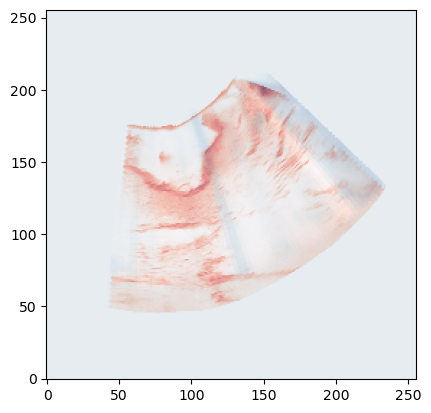

In [ ]:
plt.imshow(final_image, origin='lower', cmap='Blues', alpha=0.5, )
plt.imshow(us_slice, origin='lower', cmap='Reds', alpha=0.5)

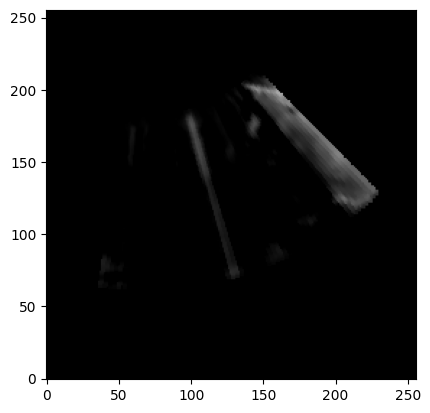

In [ ]:
# out_2 = renderer.plot_beam_frame(
#     volume=torch.tensor(Z_vol),
#     source=source,
#     directions=directions,
#     angle=np.degrees(opening_angle)/2,
#     plot=False,
#     artifacts=False,
#     start=110
# )
# x,z = rotate_around_apex(out_2[0], 
#                         out_2[1], 
#                         apex=apex_mri_world[:2],
#                         median=[-0.3,-0.9])
img = differentiable_splat(x, z, out_2[2], H=256, W=256, sigma=0.5)
plt.imshow(img.detach().numpy(), cmap='gray', vmin=0, vmax=intensities.max()*1.5, origin='lower')


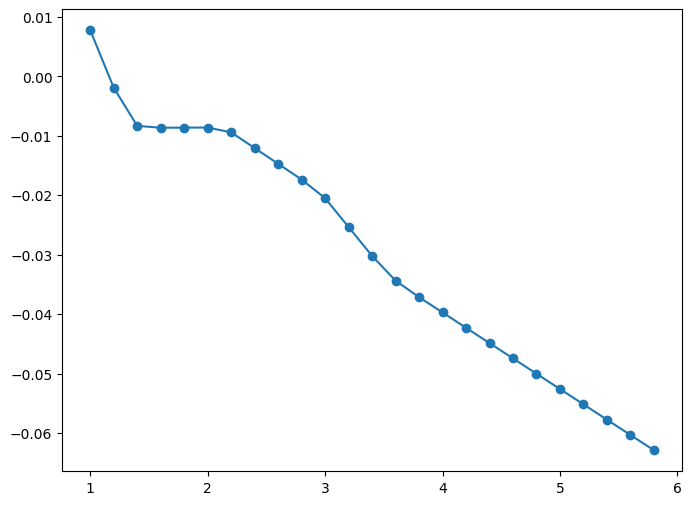

In [ ]:
x = torch.arange(1, 6, step=0.2,dtype=torch.float32).reshape(-1, 1)
y = model_one.forward(x).detach()

plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y, marker='o', label='Predicted Impedance')